# 数据预处理

加载load_iris数据到panda，选择sepal length、sepal width作为可视化特征，示例代码以分类任务为示例

In [1]:
from sklearn.datasets import load_iris
import pandas as pd

In [2]:
col_names = ['sepal length (cm)', 'sepal width (cm)',  'petal length (cm)',  'petal width (cm)']
tag_names = ['setosa', 'versicolor', 'virginica']

data = load_iris()

In [3]:
df = pd.DataFrame(data['data'])
df.columns = col_names
df['target'] = None
for i in range(df.shape[0]):
    df.at[i, 'target'] = data['target'][i]

In [4]:
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [5]:
temp = df[["sepal length (cm)", "sepal width (cm)", "target"]]
temp = temp[temp['target'] < 2]
temp

,sepal length (cm),sepal width (cm),target
0,5.1,3.5,0
1,4.9,3.0,0
2,4.7,3.2,0
3,4.6,3.1,0
4,5.0,3.6,0
...,...,...,...
95,5.7,3.0,1
96,5.7,2.9,1
97,6.2,2.9,1
98,5.1,2.5,1


随机选择setosa中的一个样本和versicolor中的一个样本,将类标设置为-1，标记为unknown类型

In [6]:
import random

test_index = []
test_index.append(random.sample (temp[temp["target"]==0].index.values.tolist(), 1)[0])
test_index.append(random.sample (temp[temp["target"]==1].index.values.tolist(), 1)[0])

print(test_index)

for index in test_index:
    temp.at[index,"target"] = -1

[13, 66]


In [7]:
temp.iloc[test_index,:]

,sepal length (cm),sepal width (cm),target
13,4.3,3.0,-1
66,5.6,3.0,-1


# 数据可视化

setosa显示为绿色，versicolor显示为红色，virginica显示为蓝色，unknown显示为灰色

In [8]:
import matplotlib.pyplot as plt

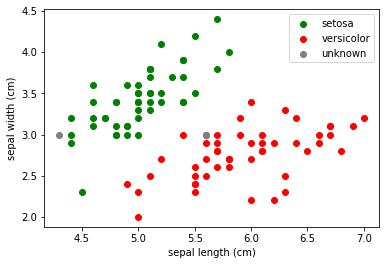

In [9]:
setosa = temp[temp['target']==0]
versicolor = temp[temp['target']==1]
unknown = temp[temp['target']==-1]

l1 = plt.scatter(setosa.loc[:,'sepal length (cm)'], setosa.loc[:, 'sepal width (cm)'], c='green')
l2 = plt.scatter(versicolor.loc[:,'sepal length (cm)'], versicolor.loc[:, 'sepal width (cm)'], c='red')
l3 = plt.scatter(unknown.loc[:,'sepal length (cm)'], unknown.loc[:, 'sepal width (cm)'], c='gray')

plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')

plt.legend(handles = [l1, l2, l3], labels = ['setosa', 'versicolor', 'unknown'], loc = 'best')

plt.show()  

# KNN 算法实现

In [10]:
import numpy as np
import heapq

In [11]:
# kd树节点类
class kdNode:
    def __init__(self, value, label, dim, left, right):
        # 保存特征向量
        self.value = value
        # 保存类标
        self.label = label
        # 当前访问特征向量的维度
        self.dim = dim
        # 左子树
        self.left = left
        # 右子树
        self.right = right
        # 要分类的新节点x与该节点的距离
        self.nearest_dist = None
    
    # 最大堆中通过nearest_dist属性进行判定大小
    def __lt__(self, other):
        return self.nearest_dist < other.nearest_dist

In [12]:
# kd树类
class kdTree:
    def __init__(self, data, label):
        # 特征向量的维度总数
        self.features_cnt = data.shape[1]
        # 递归建立kd树
        self.root = self.create(data, label, dim=0)
        # 保存与要分类节点的k近邻的节点list
        self.k_nearest_nodes = []
        # 保存类标
        self.classes = list(set(label))
    
    def create(self, data, label, dim):
        # 不能划分返回None
        if len(data) == 0:
            return None
        
        # 找到data中的中位数
        index_sorted = np.argsort(data[:,dim])
        
        data_sorted = data[index_sorted]
        
        label_sorted = label[index_sorted]

        mid = len(data_sorted)//2
        
        # 中位数左边建立左子树
        left = self.create(data_sorted[:mid], label_sorted[:mid], (dim+1) % self.features_cnt)
        
        # 中位数右侧建立右子树
        right = self.create(data_sorted[mid+1:], label_sorted[mid+1:], (dim+1) % self.features_cnt)
        
        # 返回父节点
        return kdNode(data_sorted[mid], label_sorted[mid], dim, left, right)
    
    def find_k_nearest(self, x, k=1, metrix='l2'):
        
        # mode选择采用范数
        if metrix == 'l1':
            mode = 1
        elif metrix == 'l2':
            mode = 2
        elif metrix == 'inf':
            mode = np.inf
        else:
            raise Exception("the value of metrix did not exit!")
        
        # 根据不同维度的大小关系遍历kd树，并保存遍历顺序到栈
        nodeStack = []
        cur = self.root
        while cur != None:
            nodeStack.append(cur)
            if cur.value[cur.dim] > x[cur.dim]:
                cur = cur.left
            else:
                cur = cur.right
        
        while len(nodeStack) != 0:
            
            cur = nodeStack.pop(-1)
            
            dis = np.linalg.norm(x-cur.value, mode)
            cur.nearest_dist = dis
            
            if len(self.k_nearest_nodes) < k:
                # 没找够k个直接入栈
                heapq.heappush(self.k_nearest_nodes, cur)
                heapq._heapify_max(self.k_nearest_nodes)
            else:
                # 找够k个后，替换k个中距离最大的
                if heapq.nlargest(1, self.k_nearest_nodes)[0].nearest_dist > dis:
                    heapq._heapreplace_max(self.k_nearest_nodes, cur)
            
            # 超球体是否越界，越界则需要到兄弟节点查找是否有更近的（注：更近的不一定存在）
            # dis_margin > 0表示 cur.value[cur.dim] > x[cur.dim] 则x应该正在访问左子树
            # dis_margin < 0表示 cur.value[cur.dim] < x[cur.dim] 则x应该正在访问右子树
            dis_margin = cur.value[cur.dim] - x[cur.dim]
            
            # 新循环开始后越过根节点，遍历另外一颗子树
            if cur == self.root:
                cur = cur.right if dis_margin > 0 else cur.left
                while cur != None:
                    nodeStack.append(cur)
                    if cur.value[cur.dim] > x[cur.dim]:
                        cur = cur.left
                    else:
                        cur = cur.right
            else:
                # 越界但没有越过根节点
                if len(self.k_nearest_nodes) <= k or heapq.nlargest(1, self.k_nearest_nodes)[0].nearest_dist > abs(hypersphere_radius):
                    if dis_margin < 0:
                        if cur.left != None: nodeStack.append(cur.left)
                    else:
                        if cur.right != None: nodeStack.append(cur.right)
        self.k_nearest_nodes = heapq.nsmallest(k, self.k_nearest_nodes)
        
    def classify(self, x, k):
        
        kd_tree.find_k_nearest(x, k)
        
        postive_cnt = 0
        negative_cnt = 0

        for node in kd_tree.k_nearest_nodes:
            if node.label == self.classes[0]:
                postive_cnt += 1
            else:
                negative_cnt += 1
            print(node.value, node.label, node.nearest_dist)
        
        return self.classes[0] if postive_cnt > negative_cnt else self.classes[1]

In [13]:
data = np.vstack([setosa.values[:,:2], versicolor.values[:,:2]])
label = np.hstack([setosa.values[:,2], versicolor.values[:,2]]).astype('int')
data.shape, label.shape

((98, 2), (98,))

In [14]:
kd_tree = kdTree(data, label)
test = unknown.loc[:,['sepal length (cm)','sepal width (cm)']].values

In [15]:
kd_tree.classify(x=test[0], k=5)

[4.4 3.0] 0 0.10000000000000053
[4.4 2.9] 0 0.14142135623730995
[4.6 3.1] 0 0.31622776601683783
[4.7 3.2] 0 0.4472135954999583
[4.6 3.4] 0 0.49999999999999983


0

In [16]:
kd_tree.classify(x=test[1], k=5)

[5.7 3.0] 1 0.10000000000000053
[5.4 3.0] 1 0.1999999999999993
[5.9 3.0] 1 0.3000000000000007
[5.8 2.7] 1 0.3605551275463989
[5.8 2.7] 1 0.3605551275463989


1

# sklearn对比

In [17]:
from sklearn.neighbors import KNeighborsClassifier

In [18]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(data, label)

KNeighborsClassifier()

In [22]:
neigh.predict(test)

array([0, 1])